Part 3 - History Dependence
===============================


    

In [133]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import scipy as sp

cell = 2
condition = 0

# Load data for cell 2 in condition 0
data = np.load("data.npz")["spikes_outputencoding"][cell, condition, :, :]

N,T = data.shape

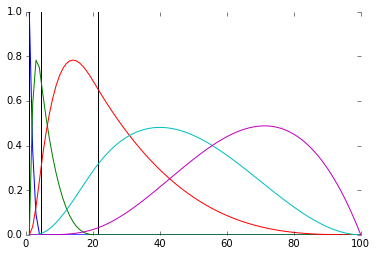

In [252]:
import splines
import statsmodels.api as sm

history_length = 100
history_spline_order = 3                          
history_num_knots = 4

# Create spline history kernel
history_x = np.linspace(1+1e-10,history_length,history_length)                            # solution
history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)              # solution
history_knots = history_knots[:-1]
history_spline_bases = np.array(splines.spcol(history_x,history_knots,history_spline_order))   # solution

figure()
axes(frameon=False)
plot(np.tile(history_knots,(2,1)),np.zeros((2,len(history_knots)))+np.array([[0],[1]]), "k-")
plot(history_x,history_spline_bases);


(288000, 5)


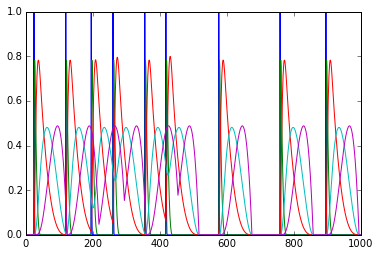

In [253]:
history_dm = np.zeros((N*T,history_num_knots+1))
spike_t = np.where(data.ravel())[0]+1
for t in spike_t:
    history_dm[t:t+history_length,:] += history_spline_bases[:min(t+history_length,N*T)-t,:]
print history_dm.shape

plot(history_dm[:1000])

(0, 14400)

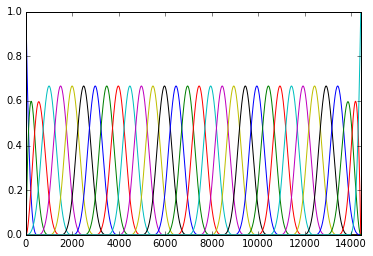

In [249]:
rate_spline_order = 3                                                      # solution
rate_num_knots = 30

rate_knots = splines.augknt(np.linspace(0,T,rate_num_knots),rate_spline_order)              # solution
rate_spline_bases = np.array(splines.spcol(np.arange(T),rate_knots,rate_spline_order))   # solution
rate_dm = np.tile(rate_spline_bases,(N,1))                                      # solution

plot(rate_dm[:T])
xlim([0,T])

In [250]:
dm = np.hstack([history_dm, rate_dm])

#plot(dm[:T])
#xlim([0,T])

model = sm.GLM(data.ravel(),dm,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(dm[:T])                       # solution

print fitted_model.llf

-11715.8935348


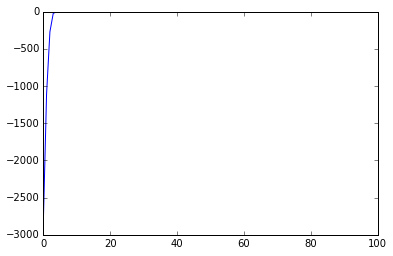

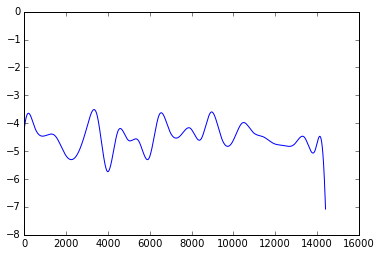

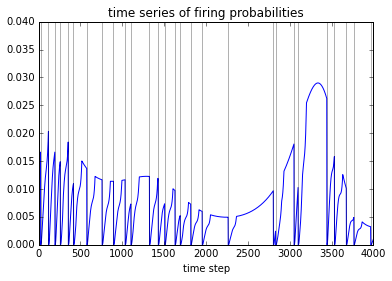

In [254]:
figure()
plot(np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1]))
xlim([0,100])

figure()
plot(np.dot(rate_spline_bases,fitted_model.params[history_num_knots+1:]))

figure()
spike_t = np.where(data[0])[0].reshape((1,-1)).repeat(2,axis=0)
spike_y = np.zeros((2,len(spike_t))) + np.array([[0],[0.4]])

plot(prediction)
plot(spike_t,spike_y,"k-", alpha=0.3)
xlim([0,4000])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')


Cross History
---------------

arr
[     9    290    530 ..., 287291 287686 287861]
arr
[    37    163    440 ..., 287639 287746 287791]
arr
[    24    130    179 ..., 287734 287785 287922]
arr
[     4    139    210 ..., 287476 287771 287803]


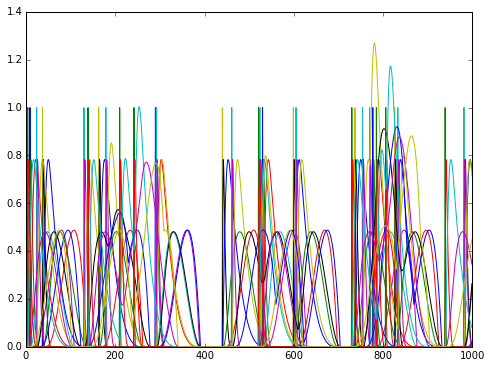

In [255]:
cross_cells = np.load("data.npz")["spikes_outputencoding"][[1,3,4,5], condition, :, :]

cross_history_dm = np.zeros((N*T,len(cross_cells)*(num_knots+1)))

for i,cross_cell in enumerate(cross_cells):
    print "arr"
    spike_t = np.where(cross_cell.ravel())[0]+1
    print spike_t
    for t in spike_t:
        cross_history_dm[t:t+history_length,i*(num_knots+1):(i+1)*(num_knots+1)] += history_spline_bases[:min(t+history_length,N*T)-t,:]

figure(figsize=(8,6))
plot(cross_history_dm[:1000])

In [256]:
dm = np.hstack([history_dm, cross_history_dm, rate_dm])

#plot(dm[:T])
#xlim([0,T])

model = sm.GLM(data.ravel(),dm,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(dm[:T])                       # solution
print fitted_model.llf

-11691.7646371


In [258]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(history_dm,fitted_model.params[:5])
cross_history_components = np.hstack([np.dot(history_dm,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])
rate_component = np.dot(rate_dm,fitted_model.params[25:])

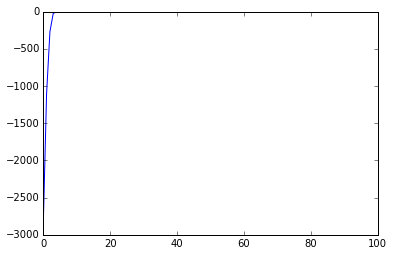

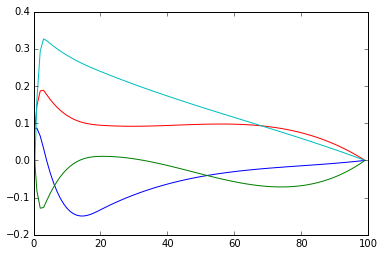

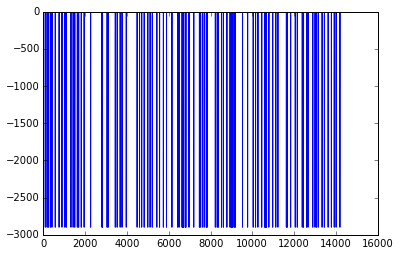

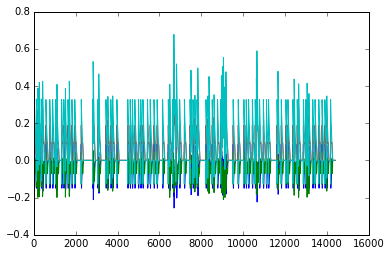

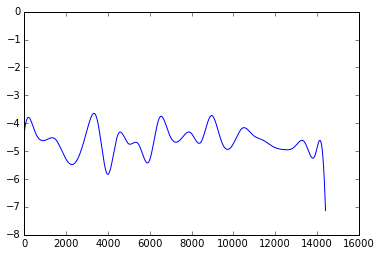

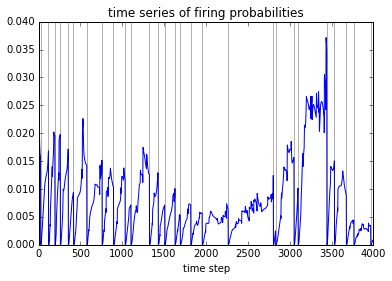

In [259]:
figure()
plot(auto_history_kernel)
xlim([0,100])

figure()
plot(cross_history_kernels)

figure()
plot(auto_history_component[:T])

figure()
plot(cross_history_components[:T])
figure()
plot(rate_component[:T])

figure()
spike_t = np.where(data[0])[0].reshape((1,-1)).repeat(2,axis=0)
spike_y = np.zeros((2,len(spike_t))) + np.array([[0],[0.4]])

plot(prediction)
plot(spike_t,spike_y,"k-", alpha=0.3)
xlim([0,4000])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

In [260]:
from scipy.special import logit

r_and_c_component = (cross_history_components.sum(axis=1) + rate_component).reshape((N,T))

spike_train = np.zeros((N,T))
for trial in range(N):
    for step in range(history_length,T):
        eta = r_and_c_component[trial,step] + np.dot(spike_train[trial,step-history_length:step],auto_history_kernel)
        p = 1/(1+np.exp(-eta))
        spike_train[trial,step] = sp.rand() < p

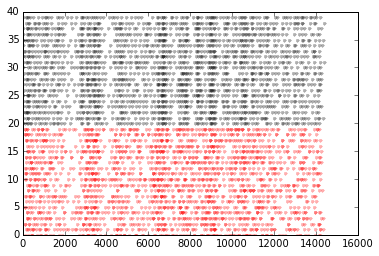

In [261]:
spike_y, spike_t = np.where(spike_train)
plot(spike_t,spike_y,"r.",alpha=0.3)

spike_y, spike_t = np.where(data)
plot(spike_t,spike_y+20,"k.",alpha=0.3)

That's it for Part 3!
==========================